In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch

def safe_float_conversion(data):
    try:
        return data.astype(float)
    except ValueError:
        # Handle or log the exception if needed
        return data

def recursively_convert_to_float(data):
    # Check if data is a numpy array (which includes structured arrays and nested arrays)
    if isinstance(data, np.ndarray):
        if data.dtype == 'O':  # For object type arrays, iterate over each element
            return np.array([recursively_convert_to_float(item.squeeze()) for item in data], dtype=float)
        else:  # Directly convert to float for other numeric types
            return data.astype(float)
    else:  # Base case for non-array data
        return float(data)

In [24]:
incident_energy = 190

In [25]:
exp_mat = scipy.io.loadmat(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/Data_folded{incident_energy:d}meV.mat')

In [26]:
flattened_data = exp_mat['data'][0][0].copy()

In [27]:
dict_out = {}

for name in flattened_data.dtype.names:
    if name == 's':
        dict_out['S'] = torch.from_numpy(flattened_data[name].astype(float))
    elif name == 'p':
        dict_out['grid'] = {}
        for _key, _array in zip(['h_grid', 'k_grid', 'l_grid', 'w_grid'], flattened_data[name][0]):
            dict_out['grid'][_key] = torch.from_numpy((_array.astype(float)[:-1] + _array.astype(float)[1:]).squeeze() / 2)

In [28]:
w_cutoff = 200
_w_grid = dict_out['grid']['w_grid']
dict_out['grid']['w_grid'] = _w_grid[_w_grid <= w_cutoff]
dict_out['S'] = dict_out['S'][...,_w_grid <= w_cutoff]

In [29]:
h_grid = dict_out['grid']['h_grid']
k_grid = dict_out['grid']['k_grid']
l_grid = dict_out['grid']['l_grid']
w_grid = dict_out['grid']['w_grid']

sqw_base = dict_out['S']

print(sqw_base.shape)

torch.Size([61, 120, 29, 61])


In [31]:
h_grid

tensor([0.0000, 0.0333, 0.0667, 0.1000, 0.1333, 0.1667, 0.2000, 0.2333, 0.2667,
        0.3000, 0.3333, 0.3667, 0.4000, 0.4333, 0.4667, 0.5000, 0.5333, 0.5667,
        0.6000, 0.6333, 0.6667, 0.7000, 0.7333, 0.7667, 0.8000, 0.8333, 0.8667,
        0.9000, 0.9333, 0.9667, 1.0000, 1.0333, 1.0667, 1.1000, 1.1333, 1.1667,
        1.2000, 1.2333, 1.2667, 1.3000, 1.3333, 1.3667, 1.4000, 1.4333, 1.4667,
        1.5000, 1.5333, 1.5667, 1.6000, 1.6333, 1.6667, 1.7000, 1.7333, 1.7667,
        1.8000, 1.8333, 1.8667, 1.9000, 1.9333, 1.9667, 2.0000],
       dtype=torch.float64)

In [32]:
k_grid

tensor([-1.9667, -1.9333, -1.9000, -1.8667, -1.8333, -1.8000, -1.7667, -1.7333,
        -1.7000, -1.6667, -1.6333, -1.6000, -1.5667, -1.5333, -1.5000, -1.4667,
        -1.4333, -1.4000, -1.3667, -1.3333, -1.3000, -1.2667, -1.2333, -1.2000,
        -1.1667, -1.1333, -1.1000, -1.0667, -1.0333, -1.0000, -0.9667, -0.9333,
        -0.9000, -0.8667, -0.8333, -0.8000, -0.7667, -0.7333, -0.7000, -0.6667,
        -0.6333, -0.6000, -0.5667, -0.5333, -0.5000, -0.4667, -0.4333, -0.4000,
        -0.3667, -0.3333, -0.3000, -0.2667, -0.2333, -0.2000, -0.1667, -0.1333,
        -0.1000, -0.0667, -0.0333,  0.0000,  0.0333,  0.0667,  0.1000,  0.1333,
         0.1667,  0.2000,  0.2333,  0.2667,  0.3000,  0.3333,  0.3667,  0.4000,
         0.4333,  0.4667,  0.5000,  0.5333,  0.5667,  0.6000,  0.6333,  0.6667,
         0.7000,  0.7333,  0.7667,  0.8000,  0.8333,  0.8667,  0.9000,  0.9333,
         0.9667,  1.0000,  1.0333,  1.0667,  1.1000,  1.1333,  1.1667,  1.2000,
         1.2333,  1.2667,  1.3000,  1.33

In [33]:
if incident_energy == 260:
    sqw_fold = torch.zeros((len(h_grid)-1)*2 + 1, len(k_grid), len(l_grid), len(w_grid))
    print(sqw_fold.shape)

    sqw_fold[sqw_fold.shape[0]//2:, :] = sqw_base
    sqw_fold[:, sqw_fold.shape[1]//2:] += sqw_base[:,:].permute(1, 0, 2, 3)
    sqw_fold += sqw_fold.flip(0).flip(1)

    for i in range(sqw_fold.shape[0]):
        # Flipped diagonal (or anti-diagonal)
        sqw_fold[i, i] /= 2
        sqw_fold[i, sqw_fold.shape[0]-i-1] /= 2
elif incident_energy == 190:
    sqw_fold = torch.zeros((len(h_grid)-1)*2 + 1, len(k_grid), len(l_grid), len(w_grid))
    print(sqw_fold.shape)

    sqw_fold[sqw_fold.shape[0]//2:, :] = sqw_base
    # sqw_fold[:, sqw_fold.shape[1]//2:] += sqw_base[:,:].permute(1, 0, 2, 3)
    # sqw_fold += sqw_fold.flip(0).flip(1)

    # for i in range(sqw_fold.shape[0]):
    #     # Flipped diagonal (or anti-diagonal)
    #     sqw_fold[i, i] /= 2
    #     sqw_fold[i, sqw_fold.shape[0]-i-1] /= 2

torch.Size([121, 120, 29, 61])


Text(0, 0.5, '$k$')

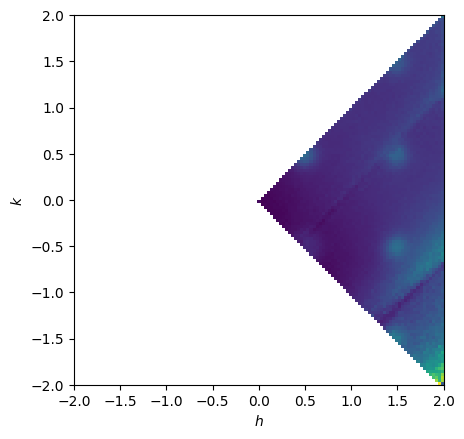

In [34]:

sqw_fold_mean = sqw_fold.sum(dim=-1).sum(dim=-1) / ((sqw_fold > 1e-10).sum(dim=-1).sum(dim=-1))
fig, ax = plt.subplots(1, 1, sharey=True)
ax.imshow(
    sqw_fold_mean.T, 
    origin='lower', extent=[-2, 2, -2, 2])
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')

In [12]:
if incident_energy == 260:
    h_grid_updated = torch.cat([-h_grid[1:].flip(dims=(0,)), h_grid], dim=0)
    k_grid_updated = k_grid
elif incident_energy == 190:
    h_grid_updated = torch.cat([-h_grid[1:-1].flip(dims=(0,)), h_grid[:-1]], dim=0)
    k_grid_updated = k_grid[:-1]

dict_save = {
    'grid': {
        'h_grid': h_grid_updated,
        'k_grid': k_grid_updated,
        'l_grid': l_grid,
        'w_grid': dict_out['grid']['w_grid']
    },
    'S': sqw_fold,
}

In [12]:
# torch.save(dict_save, f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')